# Messel Shale Food Web
**Author: Katherine Song**

Goal: find the keystone species and apex predators of the food web from the 48 million years old uppermost early Eocene Messel Shale

This data set is a food web of species found in the Messel lacustrine deposit, near Darmstadt, in central Germany, and was compiled in 2014. Each edge goes from the consumer to the consumed. (Citation at the end.) The interactions have been compiled over a large number of papers, and although the edges are weighted by certainty of the connection, I have disregarded that to make the computations easier. 

## Section 1: Visualizing the network

In [189]:
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

g = nx.read_edgelist("foodweb/edgess.csv", delimiter=",", create_using=nx.DiGraph)
print("Info:", g)
nodelist = list(g.nodes)
print(nodelist[0:10])
A = nx.to_numpy_array(g, nodelist=nodelist)

Info: DiGraph with 700 nodes and 6444 edges
['6', '125', '136', '138', '139', '215', '15', '0', '17', '124']


In [190]:
from graspologic.utils import is_fully_connected

is_fully_connected(A)

True

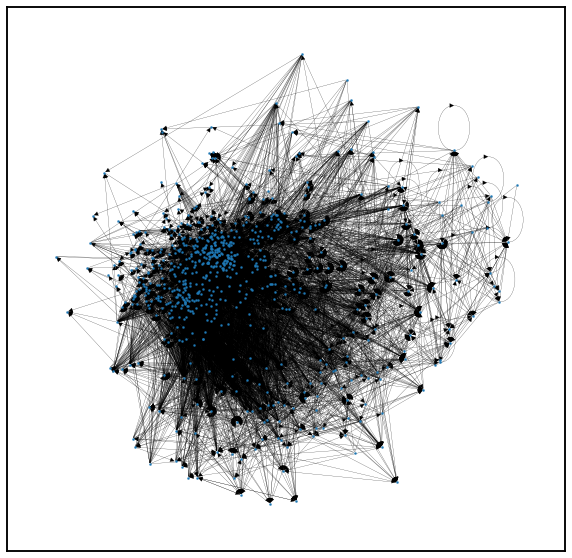

In [191]:
pos = nx.kamada_kawai_layout(g, scale=1.5) 
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nx.draw_networkx(g, pos=pos, ax=ax, with_labels=False, node_size=5, width=0.2, linewidths=0.2, arrows=None)

<AxesSubplot:>

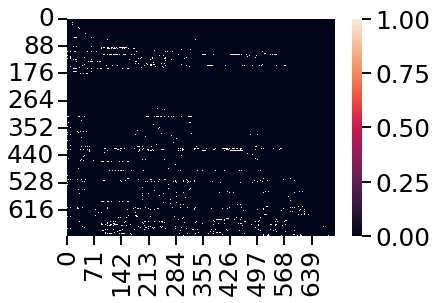

In [192]:
sns.heatmap(A) 

<AxesSubplot:>

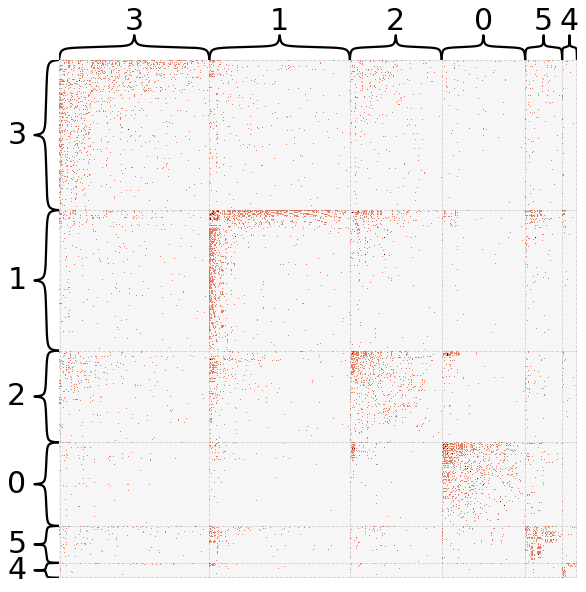

In [193]:
from graspologic.utils import symmetrize

A_s = symmetrize(A)
g_s = nx.from_numpy_matrix(A_s, parallel_edges=False, create_using=nx.Graph)
nodelist_s = list(g_s.nodes)

from graspologic.partition import leiden, modularity
from graspologic.plot import heatmap

partition_map = leiden(g_s, trials=100)
labels = np.vectorize(partition_map.get)(nodelist_s)
heatmap(A_s, inner_hier_labels=labels, sort_nodes=True, cbar=False)

In [194]:
modularity(g_s, partition_map)

0.35702805041606034

Looks like this network isn't very modular 

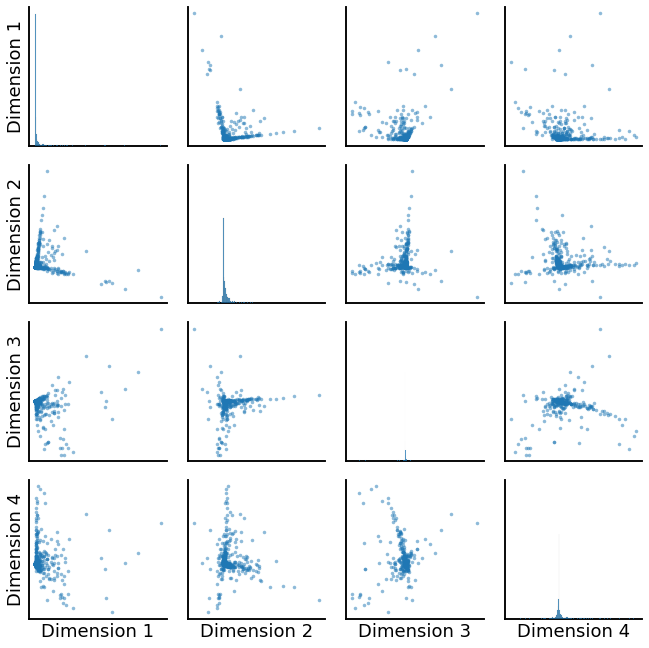

In [195]:
from graspologic.embed import AdjacencySpectralEmbed
ase = AdjacencySpectralEmbed()
X, Y = ase.fit_transform(A)

from graspologic.plot import pairplot
pairplot(X, alpha = 0.5)

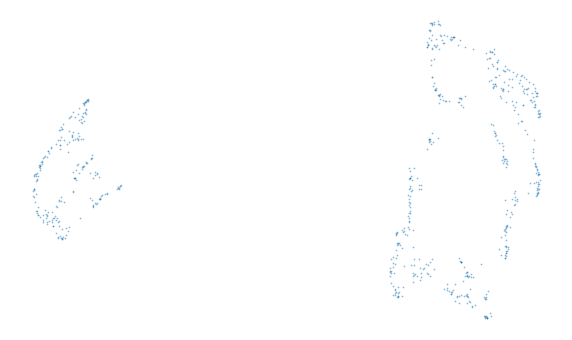

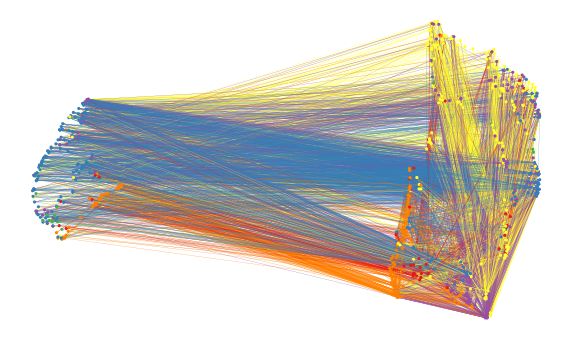

In [196]:
from umap import UMAP
umapper = UMAP(metric="canberra")
umap_ase_embedding =  umapper.fit_transform(X)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.scatterplot(
    x=umap_ase_embedding[:, 0],
    y=umap_ase_embedding[:, 1],
    ax=ax,
    s=3,
    alpha=0.5,
    linewidth=0,
)
_ = ax.axis("off")

from graspologic.plot import networkplot

ax = networkplot(
    A,
    x=umap_ase_embedding[:, 0],
    y=umap_ase_embedding[:, 1],
    node_alpha=1.0,
    edge_alpha=1.0,
    edge_linewidth=.2,
    node_hue=labels,
    node_kws=dict(s=10, linewidth=0),
    figsize=(10,6)
)

_ = ax.axis('off')

## Section 2: measuring centrality. 
I wanted to see which nodes (organisms) had the most interactions with other nodes. This could signify that the organism is a keystone species. 

### Degrees

In [197]:
def map_to_nodes(node_map):
    node_map.setdefault(0)
    return np.array(np.vectorize(lambda x: node_map.setdefault(x, 0))(nodelist))

degrees = dict(g.degree())
map_to_nodes(degrees)

in_degree = A.sum(axis=0) 
out_degree = A.sum(axis=1)
tot_degree = in_degree + out_degree

print(max(in_degree))
print(max(out_degree))
print(max(tot_degree))


51.0
191.0
192.0


Here I imported the nodes as a pandas dataframe:

In [198]:
import pandas as pd
nodes = pd.read_csv("foodweb/nodes.csv", sep=",",index_col=0, usecols=(0,1,2))
nodes.head()

,name,group
# index,,
0,detritus,detritus
1,dead animal material,carrion
2,sulphate reducing bacteria,gram-negative bacteria
3,Enterobacteriaceae,gram-negative bacteria
4,iron bacteria,gram-negative bacteria


This will print the name of the organism associated with the nodes with the highest degree values (I set it to the top five). It also adds the info to a list. 

In [199]:
#degree
dgs = map_to_nodes(dict(g.degree()))
dgs_sorted = (sorted(np.ndarray.tolist(dgs), key=float, reverse=True)) #list 

dg_list = []
for i in range (0,5):
    dg = dgs_sorted[i]
    dg_index_list = [j for j, x in enumerate(dgs) if x == dg]
    for val in dg_index_list:
        print(i, " degree: ", dg, "val: ", val, nodes.iloc[val])
        dg_list.append(nodes.iloc[val])


0  degree:  192 val:  667  name     Amphilemuridae (Macrocranion tupaidon)
 group                                Lipotyphla
Name: 667, dtype: object
1  degree:  173 val:  419  name     Chrysomelidae (Sagra sp.)
 group                   Coleoptera
Name: 419, dtype: object
2  degree:  130 val:  651  name     Fam. Indet. Palaeopsittacus cf. georgei
 group                          ?Caprimugliformes
Name: 651, dtype: object
3  degree:  124 val:  97  name     Illiciaceae (gen. et sp. indet.)
 group                          Illiciales
Name: 97, dtype: object
4  degree:  120 val:  115  name     Olacaceae (Olaxipollis matthesii )
 group                            Santalales
Name: 115, dtype: object


Note that the max degree is the same as the one that was calculated above

### Eigenvalues

This will find and list the nodes with the highest eigenvalues (again, I set it to the top five). 

In [200]:
eigenvalues = map_to_nodes(dict(nx.eigenvector_centrality(g))) #returns numpy array 

eigenvalues_sorted = (sorted(np.ndarray.tolist(eigenvalues), key=float, reverse=True)) #list 

eig_list = []
for i in range (0,5):
    eigen = eigenvalues_sorted[i]
    eigen_index_list = [j for j, x in enumerate(eigenvalues) if x == eigen]
    for val in eigen_index_list:
        print(i, " eigen: ", eigen, "val: ", val, nodes.iloc[val])
        eig_list.append(nodes.iloc[val])

0  eigen:  0.29980645686387464 val:  7  name     iron-reducing bacteria
 group    gram-negative bacteria
Name: 7, dtype: object
1  eigen:  0.21405160877201823 val:  24  name     Bacillariophyceae (Cyclotella or Cyclostephanu...
 group                                            Centrales
Name: 24, dtype: object
2  eigen:  0.18227721354061946 val:  26  name     dinoflagellate incertae sedis (Geiselodinium sp.)
 group                                          Pyrrhophyta
Name: 26, dtype: object
3  eigen:  0.1661334439304255 val:  19  name     sulfur-oxidizing bacteria
 group         Proteobacteria-gamma
Name: 19, dtype: object
4  eigen:  0.15519997600754964 val:  64  name     Cupressaceae (Sciadopityoideae)
 group                        Coniferales
Name: 64, dtype: object


### PageRank

Find and list the nodes with the highest PageRank probability values: 

In [201]:
#pagerank
pagerank_dict = nx.pagerank(g, max_iter=100)
pgranks = np.vectorize(pagerank_dict.get)(nodelist)

pgranks_sorted = (sorted(np.ndarray.tolist(pgranks), key=float, reverse=True)) #list 

pgr_list = []

for i in range (0,5):
    pgrank = pgranks_sorted[i]
    pgrank_index_list = [j for j, x in enumerate(pgranks) if x == pgrank]
    for val in pgrank_index_list:
        print(i, " pgrank: ", pgrank, "val: ", val, nodes.iloc[val])
        pgr_list.append(nodes.iloc[val])


0  pgrank:  0.010478264735163187 val:  7  name     iron-reducing bacteria
 group    gram-negative bacteria
Name: 7, dtype: object
1  pgrank:  0.005812506887787668 val:  9  name                        rods
 group    ?gram-negative bacteria
Name: 9, dtype: object
2  pgrank:  0.005620547684533226 val:  227  name     litter fungus
 group      Ascomycetes
Name: 227, dtype: object
3  pgrank:  0.005579312459082565 val:  1  name     dead animal material
 group                 carrion
Name: 1, dtype: object
4  pgrank:  0.005486826071144288 val:  226  name     Agaricales (Fam. incertae)
 group                Basidiomycetes
Name: 226, dtype: object


### Betweenness

In [202]:
betweenness_dict = nx.betweenness_centrality(g, normalized=True)
btws = np.vectorize(betweenness_dict.get)(nodelist)

btws_sorted = (sorted(np.ndarray.tolist(btws), key=float, reverse=True)) #list 

btw_list = []

for i in range (0,5):
    btw = btws_sorted[i]
    btw_index_list = [j for j, x in enumerate(btws) if x == btw]
    for val in btw_index_list:
        print(i, " betweenness: ", btw, "val: ", val, nodes.iloc[val])
        btw_list.append(nodes.iloc[val])


0  betweenness:  0.019879144639951836 val:  145  name     Juglandaceae (Engelhardia sp., Momipites punct...
 group                                              Fagales
Name: 145, dtype: object
1  betweenness:  0.017268764558405002 val:  419  name     Chrysomelidae (Sagra sp.)
 group                   Coleoptera
Name: 419, dtype: object
2  betweenness:  0.01695593901302258 val:  418  name     Cerambycidae (gen. et sp. indet., DT212
 group                                 Coleoptera
Name: 418, dtype: object
3  betweenness:  0.015464964536766521 val:  115  name     Olacaceae (Olaxipollis matthesii )
 group                            Santalales
Name: 115, dtype: object
4  betweenness:  0.010835003811673398 val:  425  name     Chrysomelidae (Bruchinae indet.)
 group                          Coleoptera
Name: 425, dtype: object


For this network, the top five for each centrality measure is very different, resulting in a lot of possible candidates for keystone species. If weights are factored in, I'd expect the results will probably be quite different as well. 

Using the lists for each centrality type, I made a dataframe in order to display them together. Here's a (somewhat more presentable) list of our candidate keystone species from each centrality type: 

In [203]:
df = pd.DataFrame({'degree': dg_list, 'eigen': eig_list, 'pagerank': pgr_list,'betweenness': btw_list})
df

,degree,eigen,pagerank,betweenness
0,name Amphilemuridae (Macrocranion tupaido...,name iron-reducing bacteria group gra...,name iron-reducing bacteria group gra...,"name Juglandaceae (Engelhardia sp., Momip..."
1,name Chrysomelidae (Sagra sp.) group ...,name Bacillariophyceae (Cyclotella or Cyc...,name rods group ?g...,name Chrysomelidae (Sagra sp.) group ...
2,name Fam. Indet. Palaeopsittacus cf. geor...,name dinoflagellate incertae sedis (Geise...,name litter fungus group Ascomycete...,"name Cerambycidae (gen. et sp. indet., DT..."
3,name Illiciaceae (gen. et sp. indet.) gr...,name sulfur-oxidizing bacteria group ...,name dead animal material group ...,name Olacaceae (Olaxipollis matthesii ) ...
4,name Olacaceae (Olaxipollis matthesii ) ...,name Cupressaceae (Sciadopityoideae) gro...,name Agaricales (Fam. incertae) group ...,name Chrysomelidae (Bruchinae indet.) gr...


A visualization of the differences between each centrality measure: 

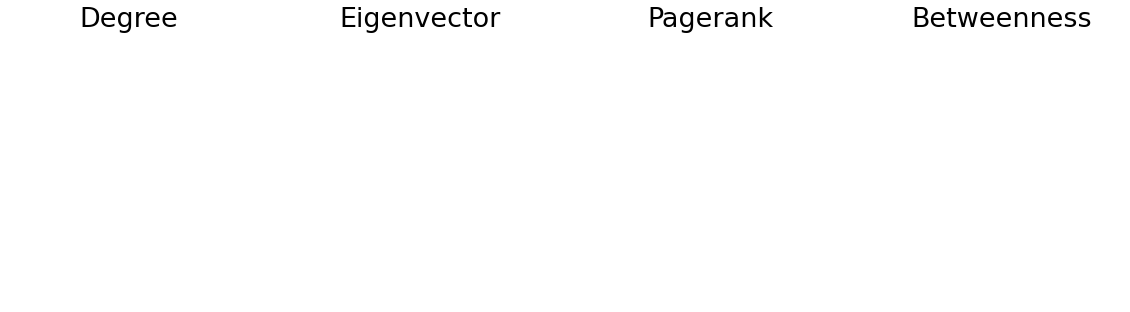

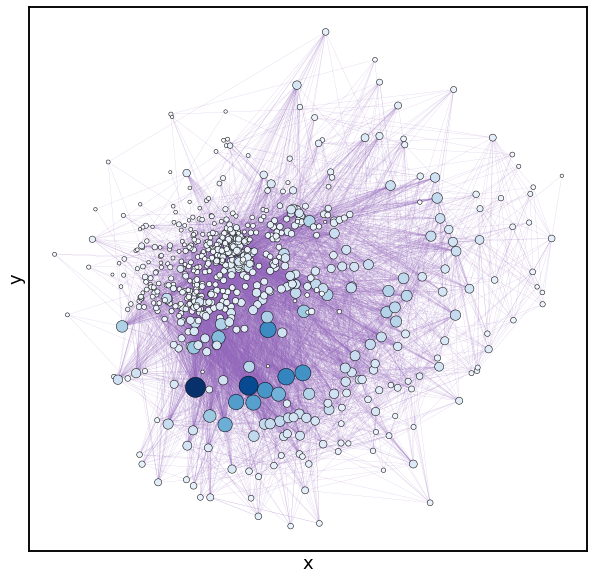

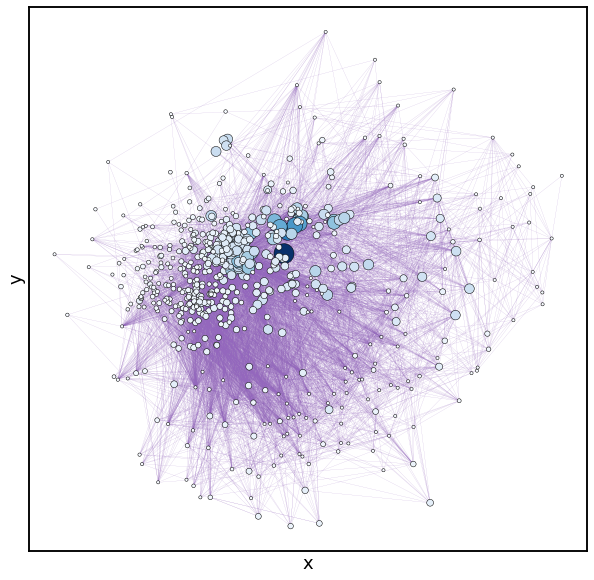

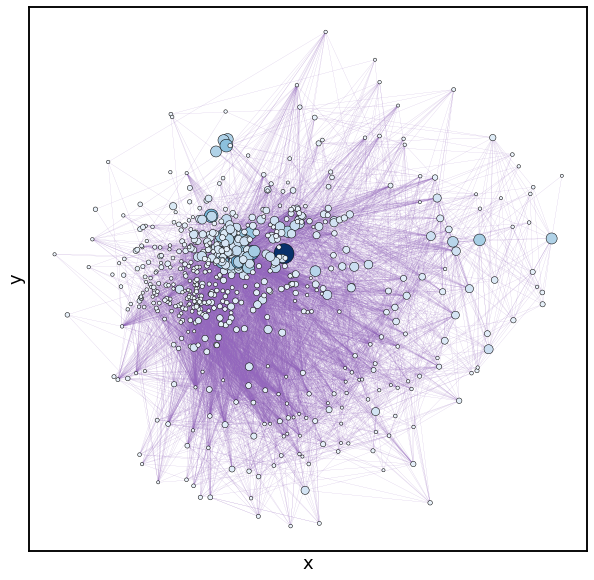

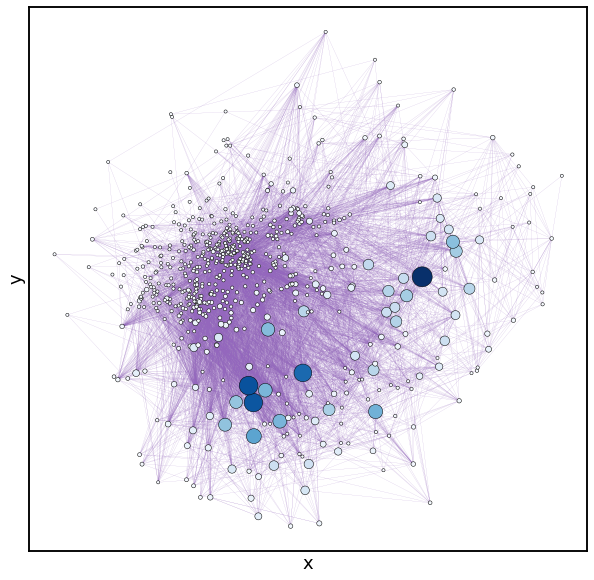

In [204]:
import matplotlib.pyplot as plt
from graspologic.plot import networkplot
import seaborn as sns
from matplotlib import colors
import  networkx as nx
import pandas as pd
import numpy as np

g = nx.read_edgelist("foodweb/edgess.csv", delimiter=",", create_using=nx.DiGraph)
nodelist = list(g.nodes)
A = nx.to_numpy_array(g, nodelist=nodelist)

node_data = pd.DataFrame(index=g.nodes())
node_data = pd.DataFrame(index=g.nodes())
node_data["degree"] = node_data.index.map(dict(nx.degree(g)))
node_data["eigenvector"] = node_data.index.map(nx.eigenvector_centrality(g))
node_data["pagerank"] = node_data.index.map(nx.pagerank(g))
node_data["betweenness"] = node_data.index.map(nx.betweenness_centrality(g))

pos = nx.kamada_kawai_layout(g)
node_data["x"] = [pos[node][0] for node in node_data.index]
node_data["y"] = [pos[node][1] for node in node_data.index]

node_data.head

sns.set_context("talk", font_scale=1.5)
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

def plot_node_scaled_network(A, node_data, key, ax):
    # REF: https://github.com/mwaskom/seaborn/blob/9425588d3498755abd93960df4ab05ec1a8de3ef/seaborn/_core.py#L215

    levels = list(np.sort(node_data[key].unique()))
    cmap = sns.color_palette("Blues", as_cmap=True)
    vmin = np.min(levels)
    norm = colors.Normalize(vmin=0.4 * vmin)
    palette = dict(zip(levels, cmap(norm(levels))))

    networkplot(
        A,
        node_data=node_data.reset_index(),  
        x="x",
        y="y",
        node_alpha=1.0,
        edge_alpha=1.0,
        edge_linewidth=0.1,
        node_hue=key,
        node_size=key,
        node_sizes=(10, 400),
        node_kws=dict(linewidth=0.5, edgecolor="black"),
        palette=palette,
        edge_kws=dict(color=sns.color_palette()[4]),
    )

    ax.axis("off")
    ax.set_title(key.capitalize())


ax = axs[0]
plot_node_scaled_network(A, node_data, "degree", ax)

ax = axs[1]
plot_node_scaled_network(A, node_data, "eigenvector", ax)

ax = axs[2]
plot_node_scaled_network(A, node_data, "pagerank", ax)

ax = axs[3]
plot_node_scaled_network(A, node_data, "betweenness", ax)

fig.set_facecolor("w")


## Rankings

Can we find out who's on the bottom and who's on the top of the food chain? 

Just using the in and out degree of each node might give us some idea. The in degree will represent the number of consumers of an organism, while the out degree represents the number of "resources" the organism consumes. The following is a list of bottom-feeders, based on the highest in-degree:

In [205]:
dgs = map_to_nodes(dict(g.in_degree()))
dgs_sorted = (sorted(np.ndarray.tolist(dgs), key=float, reverse=True)) #list 

for i in range (0,5):
    dg = dgs_sorted[i]
    dg_index_list = [j for j, x in enumerate(dgs) if x == dg]
    for val in dg_index_list:
        print(i, " degree: ", dg, "val: ", val, nodes.iloc[val])

0  degree:  51 val:  7  name     iron-reducing bacteria
 group    gram-negative bacteria
Name: 7, dtype: object
1  degree:  42 val:  1  name     dead animal material
 group                 carrion
Name: 1, dtype: object
1  degree:  42 val:  9  name                        rods
 group    ?gram-negative bacteria
Name: 9, dtype: object
2  degree:  42 val:  1  name     dead animal material
 group                 carrion
Name: 1, dtype: object
2  degree:  42 val:  9  name                        rods
 group    ?gram-negative bacteria
Name: 9, dtype: object
3  degree:  40 val:  97  name     Illiciaceae (gen. et sp. indet.)
 group                          Illiciales
Name: 97, dtype: object
4  degree:  37 val:  227  name     litter fungus
 group      Ascomycetes
Name: 227, dtype: object


Finding the organisms who consume the most other organisms: 

In [206]:
dgs = map_to_nodes(dict(g.out_degree()))
dgs_sorted = (sorted(np.ndarray.tolist(dgs), key=float, reverse=True)) #list 

for i in range (0,5):
    dg = dgs_sorted[i]
    dg_index_list = [j for j, x in enumerate(dgs) if x == dg]
    for val in dg_index_list:
        print(i, " degree: ", dg, "val: ", val, nodes.iloc[val])

0  degree:  191 val:  667  name     Amphilemuridae (Macrocranion tupaidon)
 group                                Lipotyphla
Name: 667, dtype: object
1  degree:  153 val:  419  name     Chrysomelidae (Sagra sp.)
 group                   Coleoptera
Name: 419, dtype: object
2  degree:  130 val:  651  name     Fam. Indet. Palaeopsittacus cf. georgei
 group                          ?Caprimugliformes
Name: 651, dtype: object
3  degree:  104 val:  341  name     Buprestidae (Agrilinae gen. 1)
 group                        Coleoptera
Name: 341, dtype: object
4  degree:  100 val:  115  name     Olacaceae (Olaxipollis matthesii )
 group                            Santalales
Name: 115, dtype: object


According to Wikipedia, "Macrocranion is a genus of extinct mammal," and Chrysomelidae and  Buprestidae types of beetles. That makes sense.

Let's just try ranking by consumption percentage (out degree / total degree) to see how well this holds up: 

In [207]:

out_dgs = map_to_nodes(dict(g.out_degree))
dgs = out_dgs/dgs

dgs_sorted = (sorted(np.ndarray.tolist(dgs), key=float, reverse=True)) #list 

for i in range (0,5):
    dg = dgs_sorted[i]
    dg_index_list = [j for j, x in enumerate(dgs) if x == dg]
    for val in dg_index_list:
        print(i, "consumer percentage: ", dg, "val: ", val, nodes.iloc[val])



/var/folders/5f/wknmn3k14d5fz_8gz585pj_w0000gn/T/ipykernel_46566/1807502736.py:2: RuntimeWarning: invalid value encountered in true_divide
  dgs = out_dgs/dgs


0 consumer percentage:  1.0 val:  0  name     detritus
 group    detritus
Name: 0, dtype: object
0 consumer percentage:  1.0 val:  6  name     nitrate-reducing bacteria
 group       gram-negative bacteria
Name: 6, dtype: object
0 consumer percentage:  1.0 val:  8  name     manganese-reducing bacteria
 group         gram-negative bacteria
Name: 8, dtype: object
0 consumer percentage:  1.0 val:  11  name     hydrogen bacteria (?Propionibacteriaceae)
 group                       gram-positive bacteria
Name: 11, dtype: object
0 consumer percentage:  1.0 val:  12  name           coccoid bacteria
 group    gram-positive bacteria
Name: 12, dtype: object
0 consumer percentage:  1.0 val:  15  name     Pseudmonadiaceae-like bacteria
 group              Proteobacteria-alpha
Name: 15, dtype: object
0 consumer percentage:  1.0 val:  17  name     nitrite-oxidizing bacteria
 group           Proteobacteria-beta
Name: 17, dtype: object
0 consumer percentage:  1.0 val:  18  name                   methan

There are probably a lot of organisms that have very few edges, which is why there are a lot of 1.0 percentages- things like the manganese-reducing bacteria exclusively feeding on another bacterium. This doesn't seem to be a very good metric but I'm tired so let's just pretend I was able to do upset minimization (which should probably work very well because we don't expect an organisms lower on the food chain to eat organisms higher up, except in rare cases).

Let's just say that if an organism has degree >5, then it can count as an apex predator. Here's the resulting list: 

In [186]:
degrees = map_to_nodes(dict(g.degree))
for i in range (0,5):
    dg = dgs_sorted[i]
    dg_index_list = [j for j, x in enumerate(dgs) if x == dg]
    for val in dg_index_list:
        if degrees[val] > 5:
            print(i, "consumer percentage: ", dg, "degree:", degrees[val], "val: ", val, nodes.iloc[val])

0 consumer percentage:  0.9074074074074074 degree: 108 val:  418  name     Cerambycidae (gen. et sp. indet., DT212
 group                                 Coleoptera
Name: 418, dtype: object
1 consumer percentage:  0.884393063583815 degree: 173 val:  419  name     Chrysomelidae (Sagra sp.)
 group                   Coleoptera
Name: 419, dtype: object
2 consumer percentage:  0.8571428571428571 degree: 7 val:  381  name     Elateridae (Macropunctum latiscutellum)
 group                                 Coleoptera
Name: 381, dtype: object
2 consumer percentage:  0.8571428571428571 degree: 14 val:  616  name     Pseudasturidae (Pseudasturides macrocephalus)
 group                                   Psittaciformes
Name: 616, dtype: object
2 consumer percentage:  0.8571428571428571 degree: 14 val:  631  name     Nyctibiidae (Paraprefica kelleri)
 group                       Cypselomorphae
Name: 631, dtype: object
3 consumer percentage:  0.85 degree: 60 val:  525  name     Ditrysia (fam. indet. 5

That seems to have worked a lot better! Our apex predator seems to be, Cerambycidae, which is a longhorn beetle. Fourth place-Pseudasturidae (Pseudasturides macrocephalus)- is a birdlike animal. I'd expect mammals, birds, and reptiles to be at the top of the food chain, which might be supported by better methods of ranking. 

It's interesting that the highest consumer percentage seems to be about 91%, which means that even for the most dominant organisms, about 9% of their interactions will be with another organism that wants to eat them. Fun! 

# Citations 
- Dunne Jennifer A., Labandeira Conrad C. and Williams Richard J. 2014Highly resolved early Eocene food webs show development of modern trophic structure after the end-Cretaceous extinctionProc. R. Soc. B.2812013328020133280
http://doi.org/10.1098/rspb.2013.3280